## Import libraries

In [49]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn,optim
from torch.utils.data import TensorDataset,DataLoader
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
import seaborn as sns

## Download and Preprocess Dataset

In [50]:
train_set = datasets.MNIST('/content',train=True,download=True)
test_set = datasets.MNIST('/content',train=False,download=True)

num_classes = 10

## Preprocessing

In [51]:
# inversion and normalization
invert = lambda image : 1 - image # function to invert the image
normalize = lambda image : image / 256 # function for bringing pixel values in range [0,1]

def preprocessing(dataset):
    dataset_images = dataset.data.numpy() # convert the dataset into numpy array
    dataset_labels = dataset.targets.numpy() # convert the labels into numpy array
    dataset_images = normalize(dataset_images)
    dataset_images = invert(dataset_images)
    return dataset_images,dataset_labels

train_images,train_labels = preprocessing(train_set)
test_images,test_labels = preprocessing(test_set)

## Prepare the data

In [84]:
# function for adding some more data from other classes
def put_extra_data(source_dataset_images,source_dataset_labels,target_dataset,class_num):
    for i in range(num_classes):
        if class_num != i:
            # get the indices where label == i
            temp_indices = np.asarray(np.where(source_dataset_labels == i))
            temp_indices = temp_indices.flatten()
            temp_indices = temp_indices[0:10]
            extra_images = source_dataset_images[temp_indices] # get some more negative images
            target_dataset = np.concatenate((target_dataset,extra_images))
    
    return target_dataset

def generate_labels(dataset_images,images_type):
  labels = np.zeros((dataset_images.shape[0],2))
  for i,image in enumerate(dataset_images):
    labels[i][images_type] = np.sum(dataset_images[i]) / 256
  # labels = np.full(shape=(dataset_images.shape[0],2),fill_value=[1-images_type,images_type],dtype=np.float32)
  return labels

# function to prepare the dataset for a given digit
def prepare_training_data(dataset_images,dataset_labels,class_num):
    indices = np.asarray(np.where(dataset_labels == class_num)) # indices of occurrence of digit as label
    indices = indices.flatten()
    # get the images for making positive dataset
    dataset_images_positive = dataset_images[indices] # images consisting of positive class
    dataset_labels_positive = generate_labels(dataset_images_positive,0) # generate the class labels which are the sum of pixel values
    print(dataset_images_positive.shape)
    # get the images for making negative dataset
    dataset_images_negative = invert(dataset_images_positive) # inverted images
    # dataset_images_negative = np.empty((0,28,28),dtype=np.float32)
    # dataset_images_negative = put_extra_data(dataset_images,dataset_labels,dataset_images_negative,class_num)
    print(dataset_images_negative.shape)

    # negative_data_indices = [i for i in range(len(dataset_labels)) if i not in indices]
    # dataset_images_negative = dataset_images[negative_data_indices]
    
    dataset_labels_negative = generate_labels(dataset_images_negative,1)
    # concatenate the negative and positive datasets
    modified_dataset_images = np.concatenate((dataset_images_positive,dataset_images_negative))
    modified_dataset_labels = np.concatenate((dataset_labels_positive,dataset_labels_negative))
    tensor_x = torch.Tensor(modified_dataset_images)
    tensor_y = torch.Tensor(modified_dataset_labels)
    new_dataset = TensorDataset(tensor_x,tensor_y)
    return new_dataset

def concat_datasets(dataset1_images,dataset1_labels,dataset2_images,dataset2_labels,class_num):
    # join the two datasets
    joined_dataset_images = np.concatenate((dataset1_images,dataset2_images))
    joined_dataset_labels = np.concatenate((dataset1_labels,dataset2_labels))
    
    indices = np.asarray(np.where(joined_dataset_labels == class_num)) # indices of occurrence of class as label
    indices = indices.flatten()
    dataset_images_positive = joined_dataset_images[indices] # images consisting of positive class
    dataset_labels_positive = generate_labels(dataset_images_positive,0)
    negative_data_indices = [i for i in range(len(joined_dataset_labels)) if i not in indices]
    
    dataset_images_negative = joined_dataset_images[negative_data_indices]
    dataset_labels_negative = generate_labels(dataset_images_negative,1)
    
    modified_dataset_images = np.concatenate((dataset_images_positive,dataset_images_negative))
    modified_dataset_labels = np.concatenate((dataset_labels_positive,dataset_labels_negative))
    
    tensor_x = torch.Tensor(modified_dataset_images)
    tensor_y = torch.Tensor(modified_dataset_labels)
    new_dataset = TensorDataset(tensor_x,tensor_y)
    return new_dataset

### Prepare the training set

In [85]:
class_num = 6
batch_size = 64
train_class_set = prepare_training_data(train_images,train_labels,class_num) # fetch the training set for a class
test_class_set = concat_datasets(train_images,train_labels,test_images,test_labels,class_num)
train_loader = DataLoader(train_class_set,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_class_set,batch_size=batch_size,shuffle=True) # take original testing set of all classes

(5918, 28, 28)
(5918, 28, 28)


### Plotting some data

tensor([[0.0000, 0.4758],
        [2.7066, 0.0000],
        [0.0000, 0.4216],
        [2.6854, 0.0000],
        [2.7691, 0.0000],
        [0.0000, 0.5363],
        [0.0000, 0.3044],
        [0.0000, 0.2571],
        [2.5742, 0.0000],
        [2.6969, 0.0000],
        [0.0000, 0.5560],
        [2.7087, 0.0000],
        [2.8324, 0.0000],
        [2.7530, 0.0000],
        [2.8006, 0.0000],
        [2.6368, 0.0000],
        [0.0000, 0.1789],
        [0.0000, 0.5033],
        [2.6674, 0.0000],
        [0.0000, 0.3166],
        [0.0000, 0.4759],
        [0.0000, 0.4889],
        [0.0000, 0.3385],
        [2.7212, 0.0000],
        [2.6081, 0.0000],
        [0.0000, 0.3664],
        [2.7457, 0.0000],
        [2.8544, 0.0000],
        [2.5283, 0.0000],
        [0.0000, 0.3205],
        [0.0000, 0.4626],
        [0.0000, 0.4719],
        [0.0000, 0.3620],
        [2.7811, 0.0000],
        [0.0000, 0.3240],
        [0.0000, 0.5638],
        [2.6953, 0.0000],
        [2.8282, 0.0000],
        [0.0

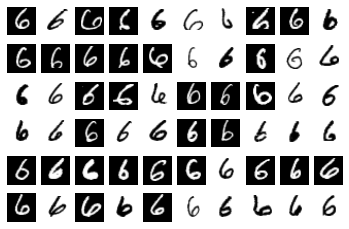

In [86]:
dataiter = iter(train_loader)
images,labels = dataiter.next()
figure = plt.figure()
print(labels)
num_of_images = 60
for index in range(1,num_of_images+1):
    plt.subplot(6,10,index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(),cmap='gray_r')

## Build the neural network

In [89]:
# Model class
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28,100),
            nn.ReLU(),
            nn.Linear(100,10),
            nn.ReLU(),
            nn.Linear(10,2)
        )
        
    def forward(self,x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

epochs = 30
model = NeuralNetwork()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(),lr=1e-3,momentum=0.9)

# function to train the model
loss_vals = []
model.train()
for e in range(epochs):
  # epoch_loss = []
  running_loss = 0.0
  for batch, (images,logits) in enumerate(train_loader):
    optimizer.zero_grad()
    # compute prediction error
    output = model(images)
    # print(output)
    # break
    loss = criterion(output,logits)
    # loss = torch.sum(criterion(output,logits),dim=1)
    # print(loss.item())
    # break
    # Backpropagation
    loss.backward()
    optimizer.step()
    # epoch_loss.append(loss.item())
    running_loss += loss.item()
  else:
    print(f"Training loss: {running_loss/len(train_loader)}")
  # plt.plot(epoch_loss)
  # break

# function to test the model
def test(dataloader,model,threshold):
  size = len(dataloader.dataset)
  model.eval()
  correct = 0
  # pred = []
  with torch.no_grad():
      for images,logits in dataloader:
        output = model(images)
        outnp = output.numpy()
        logit_np = logits.numpy()
        for i in range(len(outnp)):
          true_label = 1 if logit_np[i][0] > logit_np[i][1] else 0
          if outnp[i][0] >= threshold and true_label == 1:
            correct += 1
          elif outnp[i][0] < threshold and true_label == 0:
            correct += 1
        # correct += (output.argmax(1) == logits.argmax(1)).type(torch.float).sum().item()
        # for i in range(len(output)):
        #   pred.append(np.argmax(output.numpy()[i]))
  correct /= size
  # print(f"Accuracy : {(100*correct):>0.1f}%")
  return correct
  


Training loss: 0.13611143197914635
Training loss: 0.005780018662178033
Training loss: 0.004720421247435986
Training loss: 0.003935972973704338
Training loss: 0.0033302102363794235
Training loss: 0.002833343295355302
Training loss: 0.002459119143895805
Training loss: 0.0021593208531723233
Training loss: 0.0019137887051329018
Training loss: 0.0017068641905270115
Training loss: 0.0015346400424007427
Training loss: 0.0013911862102513378
Training loss: 0.0012672930524835514
Training loss: 0.0011608565534540528
Training loss: 0.0010679885987318247
Training loss: 0.0009874950103285545
Training loss: 0.0009171172186757463
Training loss: 0.000851973843748203
Training loss: 0.0007951326452736819
Training loss: 0.0007438595386259761
Training loss: 0.0006974406925822935
Training loss: 0.0006557094946352614
Training loss: 0.0006174073052731015
Training loss: 0.0005822327941328891
Training loss: 0.0005507557297351997
Training loss: 0.0005222260802543747
Training loss: 0.0004958945559337735
Training 

## Testing

In [90]:
# for class_num in range(num_classes):
#     train_class_set = prepare_training_data(train_images,train_labels,class_num) # fetch the training set for a class
#     test_class_set = concat_datasets(train_images,train_labels,test_images,test_labels,class_num)
#     train_loader = DataLoader(train_class_set,batch_size=64,shuffle=True)
#     test_loader = DataLoader(test_class_set,batch_size=64,shuffle=True) # take original testing set of all classes
    
#     model = NeuralNetwork()

#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.SGD(model.parameters(),lr = 1e-3,momentum=0.9)
#     print(f"Class Number: {class_num}")
#     train(train_loader,model,criterion,optimizer)
#     y_pred_train = test(train_loader,model)
#     y_pred_test = test(test_loader,model)
# lb = LabelBinarizer()
# lb.fit([0,1])
# binarized_labels = lb.transform(y_pred_test)
# binarized_labels = np.hstack((binarized_labels,1-binarized_labels))
# print(binarized_labels)

# scores = np.empty((0,3),dtype=np.float32)
data = np.empty((0,2),dtype=np.float32)

yes_scores = np.linspace(0.0,3.0,15,endpoint=True)
for threshold in yes_scores:
  accuracy = test(test_loader,model,threshold)
  data = np.vstack((data,[[threshold,accuracy]]))

df = pd.DataFrame(data)
df.columns = ['threshold','accuracy']
df
# with torch.no_grad():
#     for images,logits in test_loader:
#       output = model(images)
#       output = output.numpy()
#       logits = logits.numpy()
#       for i in range(len(output)):
#         yes_score = output[i][0]
#         no_score = output[i][1]
#         # print(no_score)
#         true_label =  1 if np.argmax(logits[i]) == 0 else 0 
#         # if true_label == 0:
#         scores = np.vstack((scores,[[yes_score,no_score,true_label]]))
#       # break
# # print(scores)

# df = pd.DataFrame(scores)
# df.columns = ['yes_score','no_score','true_label']
# df

,threshold,accuracy
0,0.000000,0.098229
1,0.214286,0.098229
2,0.428571,0.098229
3,0.642857,0.098229
4,0.857143,0.098229
5,1.071429,0.098229
6,1.285714,0.098229
7,1.500000,0.098229
8,1.714286,0.098229
9,1.928571,0.098243


### Plotting the probability scores

       threshold   accuracy
count  15.000000  15.000000
mean    1.500000   0.213119
std     0.958315   0.268048
min     0.000000   0.098229
25%     0.750000   0.098229
50%     1.500000   0.098229
75%     2.250000   0.104536
max     3.000000   0.901771


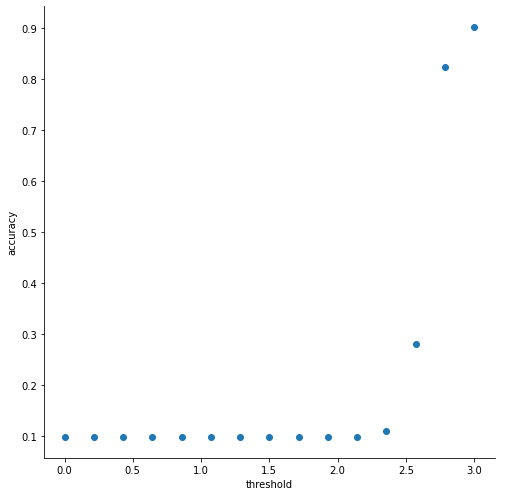

In [93]:

print(df.describe())
# sns.FacetGrid(df,hue="true_label",height=7).map(plt.scatter,"yes_score","no_score",alpha=1).add_legend()
sns.FacetGrid(df,height=7).map(plt.scatter,"threshold","accuracy").add_legend()
plt.show()

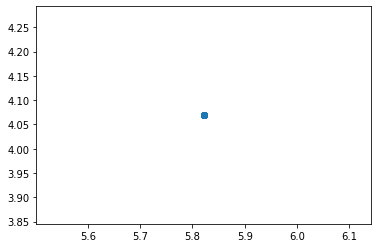

In [44]:
# plt.scatter(np.log(scores[:,0]),np.log(scores[:,1]))